### Library Import

In [7]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import xgboost as xgb

# from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns


### Data Load

In [5]:
# drive.mount('/content/drive')

# 기본 경로 설정
base_path = "/data/ephemeral/home/JihoonRyu00/data/"

# CSV 파일을 데이터프레임으로 불러오기
eda_df_filtered = pd.read_csv(os.path.join(base_path, 'eda_df_filtered.csv'))

eda_df_filtered

,target,hourly_market-data_open-interest_gate_io_btc_usd_open_interest,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations,...,hourly_market-data_liquidations_htx_global_btc_usdt_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations_usd,hourly_network-data_blockreward_blockreward_usd,hourly_network-data_addresses-count_addresses_count_active,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_addresses-count_addresses_count_sender,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations,ID
0,2.0,21461315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,1.248565e+06,67987,37752,37307,0.0,0.0,0.0,2023-01-01 00:00:00
1,1.0,21464662.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,4.176322e+05,30593,20534,12342,0.0,0.0,0.0,2023-01-01 01:00:00
2,1.0,21481446.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,8.321735e+05,33897,19369,17737,0.0,0.0,0.0,2023-01-01 02:00:00
3,1.0,21534989.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,5.199754e+05,32717,23799,11421,0.0,0.0,0.0,2023-01-01 03:00:00
4,2.0,21534219.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,0.0,7.286038e+05,45176,31712,17320,0.0,0.0,0.0,2023-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8852.6173,0.0,7.545328e+05,29250,13601,18154,0.0,0.0,0.0,2024-04-26 03:00:00
11548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,88004.5038,0.0,1.466257e+06,56580,29096,31320,0.0,0.0,0.0,2024-04-26 04:00:00
11549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24154.4771,0.0,1.447081e+06,51858,22094,34083,0.0,0.0,0.0,2024-04-26 05:00:00
11550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17703.9134,0.0,9.307435e+05,36270,12668,26186,0.0,0.0,0.0,2024-04-26 06:00:00


In [2]:
# drive.mount('/content/drive')

# 기본 경로 설정
base_path = "/data/ephemeral/home/JihoonRyu00/data/"

# CSV 파일을 데이터프레임으로 불러오기
eda_df_filtered = pd.read_csv(os.path.join(base_path, 'eda_df_filtered.csv'))

# 새로운 DataFrame을 준비
diff_df = pd.DataFrame()

# 모든 컬럼 중에서 "long_liquidations"와 "short_liquidations"로 끝나는 컬럼 찾기
long_columns = [col for col in eda_df_filtered.columns if col.endswith('long_liquidations')]
short_columns = [col for col in eda_df_filtered.columns if col.endswith('short_liquidations')]

# long_columns와 short_columns 대응이 가능한지 확인 (갯수가 같은지 등)
if len(long_columns) == len(short_columns):
    for long_col, short_col in zip(long_columns, short_columns):
        # 새로운 피처 이름 정의 (예: A-liquidation_diff)
        new_col_name = f'{long_col.replace("_long_liquidations", "")}_liquidation_diff'

        # long과 short의 차이를 새로운 피처로 추가
        diff_df[new_col_name] = eda_df_filtered[long_col] - eda_df_filtered[short_col]
else:
    print("Long과 Short 컬럼의 수가 맞지 않습니다.")



# "buy_volume"과 "sell_volume"로 끝나는 컬럼 찾기
buy_columns = [col for col in eda_df_filtered.columns if col.endswith('buy_volume')]
sell_columns = [col for col in eda_df_filtered.columns if col.endswith('sell_volume')]

# buy_columns와 sell_columns 대응이 가능한지 확인
if len(buy_columns) == len(sell_columns):
    for buy_col, sell_col in zip(buy_columns, sell_columns):
        # 새로운 피처 이름 정의 (예: A-volume_diff)
        new_col_name = f'{buy_col.replace("_buy_volume", "")}_volume_diff'

        # buy와 sell의 차이를 새로운 피처로 추가
        diff_df[new_col_name] = eda_df_filtered[buy_col] - eda_df_filtered[sell_col]
else:
    print("Buy와 Sell 컬럼의 수가 맞지 않습니다.")

# 결과 확인: diff_df에 모든 diff 값이 저장됩니다.
diff_df.T

,0,1,2,3,4,5,6,7,8,9,...,11542,11543,11544,11545,11546,11547,11548,11549,11550,11551
hourly_market-data_liquidations_bitfinex_all_symbol_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_huobi_global_all_symbol_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_bybit_all_symbol_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_huobi_global_btc_usd_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_huobi_global_btc_usdt_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_gate_io_btc_usdt_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_bitmex_all_symbol_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_gate_io_all_symbol_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_htx_global_all_symbol_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hourly_market-data_liquidations_bybit_btc_usd_liquidation_diff,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 원본 데이터와 합침 (결측값 처리 필요)
eda_diff = pd.concat([eda_df_filtered, diff_df], axis=1)

In [8]:
# drive.mount('/content/drive')

# # CSV 파일을 데이터프레임으로 불러오기
# eda_df_filtered = pd.read_csv('/content/drive/MyDrive/data/data/eda_df_filtered.csv')

# 원본 데이터 유지
# eda_df_shifted = eda_df_filtered.copy()



# Shift를 적용할 시간 단위
shift_units = [1, 2, 3, 4, 6, 12, 24]

# ID, target, _type 같은 칼럼 제외
features_to_shift = eda_df_filtered.drop(columns=['ID', 'target', '_type']).columns

# 빈 DataFrame을 준비
shifted_features = []

# 각 피처에 대해 여러 시간 단위로 시프트 적용
for feature in features_to_shift:
    for shift_unit in shift_units:
        shifted_feature = eda_df_filtered[feature].shift(shift_unit).rename(f'{feature}_shift_{shift_unit}h')
        shifted_features.append(shifted_feature)

# 모든 시프트된 피처를 한 번에 concat
shifted_features_df = pd.concat(shifted_features, axis=1)


In [9]:
# 원본 데이터와 합침 (결측값 처리 필요)
eda_diff_shifted = pd.concat([eda_diff, shifted_features_df], axis=1)

In [10]:
# 모든 피처에 대해 세 가지 롤링 윈도우 적용 (mean, std, sum)
window_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 24, 24*7]  # 24시간, 7일

# 원본 데이터 유지
# eda_df_rolled = eda_diff_shifted.copy()

# ID, target, _type 같은 칼럼 제외
features_to_roll = eda_diff_shifted.drop(columns=['ID', 'target', '_type']).columns

# 빈 DataFrame을 준비
rolling_features = []

# 각 피처에 대해 세 가지 롤링 윈도우(24시간, 7일) 적용
for feature in features_to_roll:
    for window_size in window_sizes:
        rolling_mean = eda_diff_shifted[feature].rolling(window=window_size).mean().rename(f'{feature}_rolling_mean_{window_size}h')
        rolling_std = eda_diff_shifted[feature].rolling(window=window_size).std().rename(f'{feature}_rolling_std_{window_size}h')
        rolling_sum = eda_diff_shifted[feature].rolling(window=window_size).sum().rename(f'{feature}_rolling_sum_{window_size}h')

        rolling_features.append(rolling_mean)
        rolling_features.append(rolling_std)
        rolling_features.append(rolling_sum)

# 모든 롤링 피처를 한 번에 concat
rolling_features_df = pd.concat(rolling_features, axis=1)

# 원본 데이터와 합침 (결측값 처리 필요)
eda_diff_shifted_rolled = pd.concat([eda_diff_shifted, rolling_features_df], axis=1)


In [12]:
eda_diff_shifted_rolled.to_csv(os.path.join(base_path, 'eda_diff_shifted_rolled_data.csv'), index=False)

KeyboardInterrupt: 

In [3]:
eda_diff_shifted_rolled=pd.read_csv(os.path.join(base_path, 'eda_diff_shifted_rolled_data.csv'))

In [4]:
# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = eda_diff_shifted_rolled["target"]
eda_diff_shifted_rolled = eda_diff_shifted_rolled.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train 분리
train_df = eda_diff_shifted_rolled.loc[eda_diff_shifted_rolled["_type"]=="train"].drop(columns=["_type"])
# test_df = eda_df_rolled_and_diff.loc[eda_diff_shifted_rolled["_type"]=="test"].drop(columns=["_type"])

train_df

,target,hourly_market-data_open-interest_gate_io_btc_usd_open_interest,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations,...,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_sum_10h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_mean_12h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_std_12h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_sum_12h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_mean_24h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_std_24h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_sum_24h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_mean_168h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_std_168h,hourly_market-data_liquidations_htx_global_btc_usd_long_liquidations_shift_24h_rolling_sum_168h
0,2.0,21461315.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
1,1.0,21464662.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
2,1.0,21481446.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
3,1.0,21534989.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
4,2.0,21534219.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1.0,8229136.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.000000,...,0.280825,0.067836,0.167320,0.814035,0.581549,2.678321,13.957164,0.154823,1.090076,26.010258
8756,1.0,8218627.0,0.0,0.0,0.0,0.0,102175.4826,2.394,103766.3419,2.441000,...,0.280825,0.023402,0.081067,0.280825,0.581549,2.678321,13.957164,0.154823,1.090076,26.010258
8757,0.0,8213394.0,0.0,0.0,0.0,0.0,15757.4003,0.368,127.3455,0.003000,...,0.280825,0.023402,0.081067,0.280825,0.581549,2.678321,13.957164,0.154823,1.090076,26.010258
8758,2.0,8225802.0,0.0,0.0,0.0,0.0,7435.0124,0.175,264810.3290,6.266413,...,0.280825,0.023402,0.081067,0.280825,0.033918,0.120788,0.814035,0.154823,1.090076,26.010258


In [8]:
# 모델 훈련을 위한 X, y 분리 (target: 예측할 값)
X = train_df.drop(columns=['target', 'ID'])  # 타겟 변수 제외
y = train_df['target']  # 타겟 변수

# XGBoost 모델 생성 및 훈련
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # XGBoost 다중 클래스 분류
model.fit(X, y)

# 피처 중요도 추출
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})

In [ ]:
# 중요도 순으로 정렬
feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)

# 전체 피처에 대한 순위 추가
feature_importances_sorted['rank'] = np.arange(1, len(feature_importances_sorted) + 1)

# 상위 50개 중요도 피처
top_50_features = feature_importances_sorted.head(50)

# 중요도 상위 50개의 피처 이름 리스트
top_50_feature_names = top_50_features['feature'].tolist()

# eda_df_rolled_and_diff에서 상위 50개의 피처만 선택
top_50_data = eda_diff_shifted_rolled[top_50_feature_names + ['target', '_type', 'ID']]

# 상위 50개 피처를 포함한 데이터를 CSV로 저장
top_50_data.to_csv(os.path.join(base_path, 'top_50_important_features_data_XGB.csv'), index=False)


# 출력 너비 설정 (길게 출력되도록 설정)
pd.set_option('display.max_colwidth', None)

# 상위 50개 피처 출력
print("Top 50 Feature Importances with Ranking:")

top_50_features

Top 50 Feature Importances with Ranking:


,feature,importance,rank
1543,hourly_network-data_tokens-transferred_tokens_transferred_total_shift_4h,17,1
15,hourly_market-data_taker-buy-sell-stats_bitmex_taker_sell_volume,15,2
139,hourly_market-data_taker-buy-sell-stats_binance_taker_sell_ratio,14,3
25106,hourly_market-data_open-interest_htx_global_all_symbol_open_interest_shift_24h_rolling_mean_168h,14,4
237,hourly_market-data_taker-buy-sell-stats_binance_taker_volume_diff,14,5
2433,hourly_market-data_open-interest_deribit_btc_usd_open_interest_rolling_std_3h,13,6
53910,hourly_market-data_open-interest_binance_btc_usd_open_interest_shift_3h_rolling_std_2h,12,7
8874,hourly_network-data_addresses-count_addresses_count_receiver_rolling_std_2h,11,8
61,hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio,11,9
50490,hourly_network-data_utxo-count_utxo_count_shift_12h_rolling_std_2h,11,10


In [ ]:
df=pd.read_csv(os.path.join(base_path, 'top_50_important_features_data_XGB.csv'))

In [ ]:
df=top_50_data

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
# _target = df["target"]

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

In [ ]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 1,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

c:\Users\harry\anaconda3\envs\bitcoin\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


acc: 0.4560502283105023, auroc: 0.6501156595149256


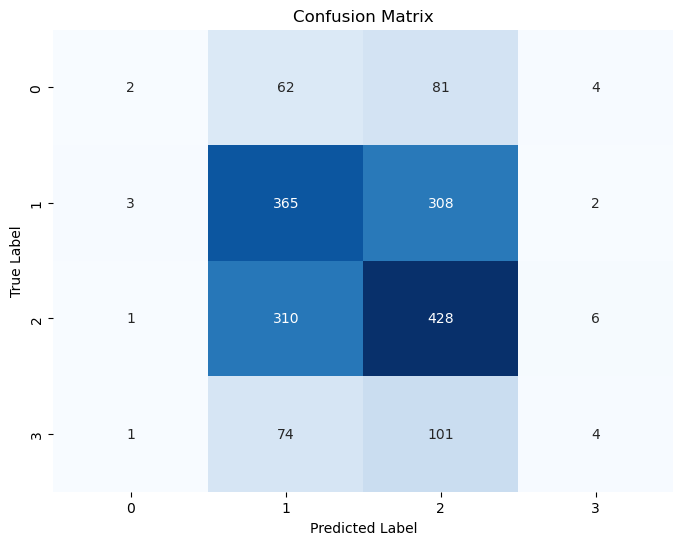

In [ ]:
from sklearn.metrics import confusion_matrix

# 혼동행렬 생성
conf_matrix = confusion_matrix(y_valid, y_valid_pred_class)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()